In [8]:
import torch
import torch.nn as nn
import datetime
import torch.nn.functional as F
from env_parallel import Env
from ppo import Agent
import torch.nn.init as init
import numpy as np

In [2]:
class PolicyValueModel(nn.Module):
    def __init__(self, count_of_actions):
        super(PolicyValueModel, self).__init__()

        self.conv1 = nn.Conv2d(2, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)

        self.fc_p1 = nn.Linear(32, 16)
        self.fc_p2 = nn.Linear(16, count_of_actions)

        self.fc_v1 = nn.Linear(32, 16)
        self.fc_v2 = nn.Linear(16, 1)

        features_layers = [self.conv1, self.conv2]
        for layer in features_layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

        output_layers = [self.fc_p1, self.fc_p2, self.fc_v1, self.fc_v2]
        for layer in output_layers:
            torch.nn.init.xavier_normal_(layer.weight)
            torch.nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 32)

        x_logit = F.relu(self.fc_p1(x))
        logit = self.fc_p2(x_logit)

        x_value = F.relu(self.fc_v1(x))
        value = self.fc_v2(x_value)

        return logit, value


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)
start_date = datetime.datetime.now()

env_candidates = 87
env_p = 8
env_count = 50
results_path = 'results/'

env = Env(env_p, env_candidates, env_count, 'data/BA-87', device)

net = PolicyValueModel(env_candidates)
# net = torch.load('models/save.net')

agent = Agent(net, device=device,
              lr=0.01, name='p_med', results_path=results_path)

agent.train(env=env, count_of_envs=env_count, input_dim=(2, env_candidates, env_candidates),
            count_of_iterations=5, count_of_steps=512, batch_size=512)

# agent.test(env)

print(datetime.datetime.now() - start_date)


device:  cpu
optimizer: Adam
Training is starting
iteration:        0 	epsiode:  50 	score:  -43.4330 	avg score:  -60.2610 	best score:  -34.8190 	best avg score:  -60.2610 	Best obj: 34819.0
iteration:        0 	epsiode:  100 	score:  -56.9260 	avg score:  -61.0183 	best score:  -34.8190 	best avg score:  -60.2610 	Best obj: 34819.0
iteration:        0 	epsiode:  150 	score:  -102.9760 	avg score:  -61.9404 	best score:  -34.8190 	best avg score:  -60.2610 	Best obj: 34819.0
iteration:        0 	epsiode:  200 	score:  -58.7340 	avg score:  -63.2406 	best score:  -34.8190 	best avg score:  -60.2610 	Best obj: 34819.0
iteration:        0 	epsiode:  250 	score:  -95.5180 	avg score:  -64.3084 	best score:  -34.8190 	best avg score:  -60.2610 	Best obj: 34819.0
iteration:        0 	epsiode:  300 	score:  -41.6320 	avg score:  -62.7267 	best score:  -34.8190 	best avg score:  -60.2610 	Best obj: 34819.0
iteration:        0 	epsiode:  350 	score:  -123.0770 	avg score:  -63.2374 	best scor

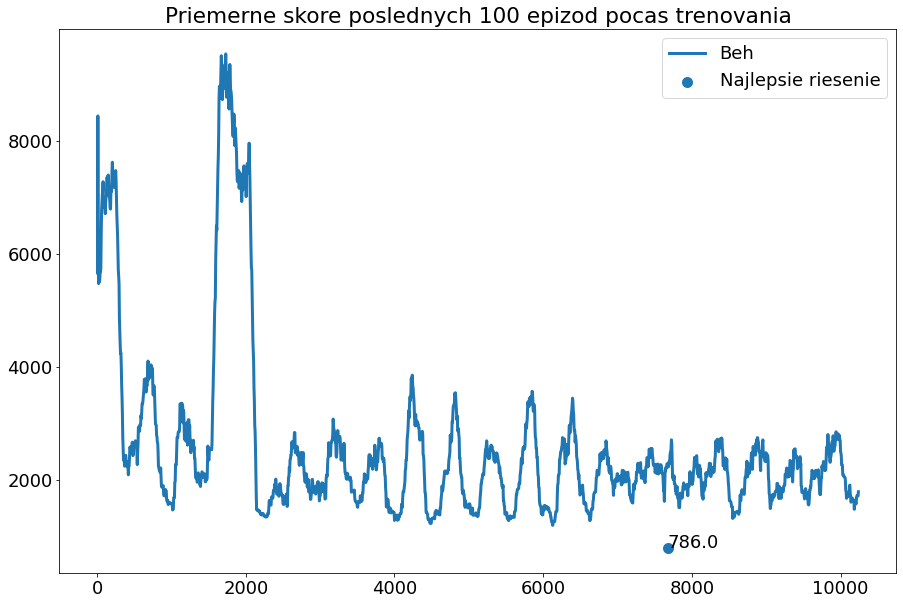

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 18})

plt.title('Priemerne skore poslednych 100 epizod pocas trenovania')
# plt.axhline(y=22506, color='r', label='Optimalne riesenie')
data = pd.read_csv(f'results/p_med.csv')
d = data['avg_score'] * -10000
plt.plot(data['episode'], d, linewidth=3, label=f'Beh')
# print("min" + str(np.min(d)))

obj = json.load(open('results/p_med_result.json'))

# x = [845500, 659500, 658500]
# y = [22506, 22506, 22591]
# c = ['tab:blue', 'orange', 'green']

plt.scatter(obj['episode'], obj['best_obj'], linewidths=5, label='Najlepsie riesenie')
plt.annotate(obj['best_obj'], (obj['episode'], obj['best_obj']))

plt.legend()
